# Генеративно-сотязательные сети, DCGUN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import random_split

## Generators

### Generator v1

In [3]:
class CSPBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super(CSPBlock, self).__init__()
        if hidden_channels is None:
            hidden_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class Generator_1(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super(Generator_1, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            CSPBlock(features_g * 16, features_g * 8),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            CSPBlock(features_g * 4, features_g * 2),
            self._block(features_g * 2, features_g, 4, 2, 1),
            CSPBlock(features_g, features_g),
            nn.ConvTranspose2d(features_g, img_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(img_channels, img_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(img_channels, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, input):
        input = input.view(input.size(0), input.size(1), 1, 1)  # Изменение размера входного тензора
        return self.gen(input)

In [3]:
# Проверим, правильно ли теперь работает генератор
z = torch.randn(10, 100)  # Batch size of 10, noise dimension 100
print('Входной батч -', z.shape)
fake_images = Generator_1(z_dim=100, img_channels=3, features_g=128)(z)

print('Выходной батч -', fake_images.shape)

Входной батч - torch.Size([10, 100])
Выходной батч - torch.Size([10, 3, 128, 128])


### Generator v2

In [4]:
class CSPupBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super(CSPupBlock, self).__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

class Generator_2(nn.Module):
    def __init__(self):
        super(Generator_2, self).__init__()
        self.initial_linear = nn.Linear(100, 4*4*1024)
        self.initial_relu = nn.ReLU(True)

        # Defining CSPup blocks
        self.block1 = CSPupBlock(1024, 512)  # Output size: 8x8
        self.block2 = CSPupBlock(512, 256)   # Output size: 16x16
        self.block3 = CSPupBlock(256, 128)   # Output size: 32x32
        self.block4 = CSPupBlock(128, 64)    # Output size: 64x64

        # Final layer to get the RGB image
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Tanh activation to get the output in the range [-1, 1]
        )

    def forward(self, z):
        z = self.initial_linear(z)
        z = z.view(-1, 1024, 4, 4)
        z = self.initial_relu(z)

        z = self.block1(z)
        z = self.block2(z)
        z = self.block3(z)
        z = self.block4(z)
        out = self.final_layer(z)

        return out

In [5]:
# Проверим, правильно ли теперь работает генератор
z = torch.randn(10, 100)  # Batch size of 10, noise dimension 100
print('Входной батч -', z.shape)
fake_images = Generator_2()(z)

print('Выходной батч -', fake_images.shape)

Входной батч - torch.Size([10, 100])
Выходной батч - torch.Size([10, 3, 128, 128])


## Discriminators

### Discriminator v2

In [6]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Вход: 3 x 128 x 128

            nn.Conv2d(img_channels, features_d, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d),
            nn.LeakyReLU(0.2, inplace=True),
            # Промежуточный размер: 64 x 64 x 64

            nn.Conv2d(features_d, features_d*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2, inplace=True),
            # Промежуточный размер: 128 x 32 x 32

            nn.Conv2d(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2, inplace=True),
            # Промежуточный размер: 256 x 16 x 16

            nn.Conv2d(features_d*4, features_d*5, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d*5),
            nn.LeakyReLU(0.2, inplace=True),
            # Промежуточный размер: 512 x 8 x 8

            nn.Conv2d(features_d*5, features_d*6, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d*6),
            nn.LeakyReLU(0.2, inplace=True),
            # Промежуточный размер: 1024 x 4 x 4

            nn.Conv2d(features_d*6, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # Выход: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.disc(x)

In [7]:
# Проверим, правильно ли теперь работает дискриминатор
input_tensor = torch.randn(32, 3, 128, 128)
output = Discriminator(img_channels=3, features_d=64)(input_tensor)
print(output.shape)

torch.Size([32, 1])


## Dataset

In [8]:
class CelebADataset(Dataset):
    def __init__(self, image_dir: str | Path, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Add an extra dimension for batch size
        image = image.unsqueeze(0)

        return image

## Подготовка к обучению

### Функции для обучения

In [9]:
def train(
    train_dataloader, 
    discriminator,
    generator,
    criterion,
    shedul_step=1
):
    G_losses = []
    D_losses = []

    for data in tqdm(enumerate(train_dataloader, 1)):
        i, data = data
        real_data = data.to(device)
        if (shedul_step is None) or (not i % shedul_step):
            # Обучение дискриминатора на реальных данных
            data = data.squeeze()
            discriminator.zero_grad()
            real_data = data.to(device)
            b_size = real_data.size(0)
            label = torch.full((b_size,), 1, dtype=torch.float, device=device)
            output = discriminator(real_data).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()

            # Обучение дискриминатора на фейковых данных
            noise = torch.randn(b_size, z_dim, device=device)
            fake = generator(noise)
            label.fill_(0)
            output = discriminator(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()

            errD = errD_real + errD_fake
            optimizerD.step()

            # Обновление генератора
            generator.zero_grad()
            label.fill_(1)  # фейковые метки считаются реальными для генератора
            output = discriminator(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        else:
            b_size = real_data.size(0)
            label = torch.full((b_size,), 1, dtype=torch.float, device=device)
            label.fill_(1)  # фейковые метки считаются реальными для генератора
            noise = torch.randn(b_size, z_dim, device=device)
            fake = generator(noise)
            output = discriminator(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()
            # Сохранение потерь для последующего анализа
            G_losses.append(errG.item())
            D_losses.append(0)

    return G_losses[::10], D_losses[::10]

In [10]:
@torch.inference_mode()
def test(
    test_dataloader, 
    discriminator,
    generator,
    criterion
):
    G_losses = []
    D_losses = []

    for data in tqdm(test_dataloader):
        data = data.squeeze()
        # Обучение дискриминатора на реальных данных
        real_data = data.to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = discriminator(real_data).view(-1)
        errD_real = criterion(output, label)

        # Обучение дискриминатора на фейковых данных
        noise = torch.randn(b_size, z_dim, device=device)
        fake = generator(noise)
        label.fill_(0)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)

        errD = errD_real + errD_fake

        # Обновление генератора
        label.fill_(1)  # фейковые метки считаются реальными для генератора
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)

        # Сохранение потерь для последующего анализа
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    return G_losses[::10], D_losses[::10]

In [11]:
def train_loop(
    train_dataloader, 
    test_dataloader,
    discriminator,
    generator,
    criterion,
    shedul_step=1,
    num_epochs=5
):
    G_losses_train, D_losses_train = [], []
    G_losses_test, D_losses_test = [], []

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Цикл обучения
    for epoch in range(num_epochs):

        G_losses_train_temp, D_losses_train_temp = train(
            train_dataloader, 
            discriminator,
            generator,
            criterion,
            shedul_step
        )
        print(f'\nTRAIN epoch_{epoch}'
              f'\nG_loss:{sum(G_losses_train_temp)/ len(G_losses_train_temp):.5}'
              f'\nD_loss:{sum(D_losses_train_temp)/ len(D_losses_train_temp):.5}\n'
             )
        
        G_losses_test_temp, D_losses_test_temp = test(
            test_dataloader, 
            discriminator,
            generator,
            criterion
        )
        print(f'\nTEST epoch_{epoch}'
              f'\nG_loss:{sum(G_losses_test_temp)/ len(G_losses_test_temp):.5}'
              f'\nD_loss:{sum(D_losses_test_temp)/ len(D_losses_test_temp):.5}\n'
             )

        G_losses_train += G_losses_train_temp
        G_losses_test += G_losses_test_temp
        D_losses_train += D_losses_train_temp
        D_losses_test += D_losses_test_temp

    # График для тренировочного набора
    axs[0].set_title("Generator and Discriminator Loss (Training)")
    axs[0].plot(G_losses_train, label="G (Train)")
    axs[0].plot(D_losses_train, label="D (Train)")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # График для тестового набора
    axs[1].set_title("Generator and Discriminator Loss (Test)")
    axs[1].plot(G_losses_test, label="G (Test)")
    axs[1].plot(D_losses_test, label="D (Test)")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    axs[0].set_xlim(0, 20)
    axs[1].set_xlim(0, 20)

    # Обновление графиков
    display(fig)
    
    return G_losses_train, D_losses_train, G_losses_test, D_losses_test

### Инициализация датасета

In [12]:
image_path = Path('/', 'kaggle', 'input', 'celeba-dataset', 'img_align_celeba', 'img_align_celeba')

In [13]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Создание экземпляра датасета
celeba_dataset = CelebADataset(image_dir=image_path, transform=transform)

In [14]:
train_size = int(0.8 * len(celeba_dataset))
test_size = len(celeba_dataset) - train_size

# Случайное разделение
train_dataset, test_dataset = random_split(celeba_dataset, [train_size, test_size])

In [15]:
batch_siza = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_siza, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_siza, shuffle=True, num_workers=2)

print(f"Загружено изображений: {len(celeba_dataset)} = {len(train_dataset)} + {len(test_dataset)}")

Загружено изображений: 202599 = 162079 + 40520


## Обучение

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Variant 1

In [17]:
z_dim = 100  # размерность входного шума
img_channels = 3  # количество каналов изображения (для RGB)
features_d = 128  # определяет сложность модели дискриминатора
features_g = 128  # количество фичей, которое будет использовать генератор

# Оптимизаторы
lr = 0.0002
beta1 = 0.5

In [18]:
generator_1 = Generator_1(z_dim, img_channels, features_g).to(device)
optimizerG = optim.Adam(generator_1.parameters(), lr=lr, betas=(beta1, 0.999))

In [19]:
discriminator_1 = Discriminator(img_channels, features_d).to(device)
optimizerD = optim.Adam(discriminator_1.parameters(), lr=lr, betas=(beta1, 0.999))

In [20]:
# Функция потерь
criterion = nn.BCELoss()

5065it [16:53,  5.00it/s]



TRAIN epoch_0
G_loss:10.073
D_loss:0.083091



100%|██████████| 1267/1267 [02:40<00:00,  7.87it/s]


TEST epoch_0
G_loss:12.027
D_loss:1.1216e-05




5065it [16:52,  5.00it/s]



TRAIN epoch_1
G_loss:14.316
D_loss:2.8715e-06



100%|██████████| 1267/1267 [01:24<00:00, 15.03it/s]


TEST epoch_1
G_loss:16.335
D_loss:2.3424e-07




5065it [16:52,  5.00it/s]



TRAIN epoch_2
G_loss:16.979
D_loss:1.7962e-07



100%|██████████| 1267/1267 [01:24<00:00, 15.02it/s]



TEST epoch_2
G_loss:19.132
D_loss:1.2801e-08



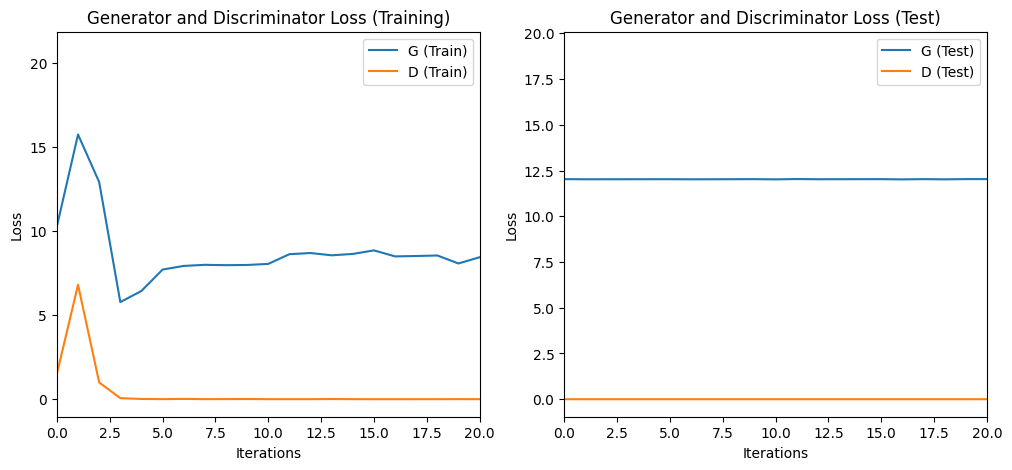

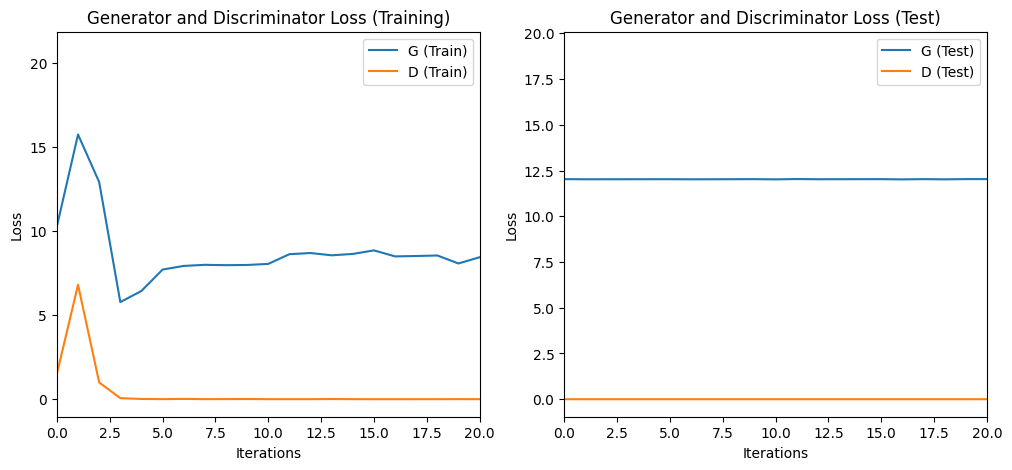

In [21]:
G_losses_train_1, D_losses_train_1, G_losses_test_1, D_losses_test_1 = train_loop(
    train_dataloader, 
    test_dataloader,
    discriminator_1,
    generator_1,
    criterion,
    shedul_step=1,
    num_epochs=3
)

### Variant 2

In [22]:
z_dim = 100  # размерность входного шума
img_channels = 3  # количество каналов изображения (для RGB)
features_d = 128  # определяет сложность модели дискриминатора
features_g = 128  # количество фичей, которое будет использовать генератор

# Оптимизаторы
lr = 0.0002
beta1 = 0.5

In [23]:
generator_2 = Generator_1(z_dim, img_channels, features_g).to(device)
optimizerG = optim.Adam(generator_2.parameters(), lr=lr, betas=(beta1, 0.999))

In [24]:
discriminator_2 = Discriminator(img_channels, features_d).to(device)
optimizerD = optim.Adam(discriminator_2.parameters(), lr=lr, betas=(beta1, 0.999))

In [25]:
# Функция потерь
criterion = nn.BCELoss()

5065it [08:43,  9.67it/s]



TRAIN epoch_0
G_loss:5.9411
D_loss:0.0



100%|██████████| 1267/1267 [01:24<00:00, 15.02it/s]


TEST epoch_0
G_loss:4.3479
D_loss:0.077492




5065it [08:43,  9.68it/s]



TRAIN epoch_1
G_loss:5.5945
D_loss:0.0



100%|██████████| 1267/1267 [01:24<00:00, 15.01it/s]


TEST epoch_1
G_loss:7.1012
D_loss:2.1283




5065it [08:44,  9.66it/s]



TRAIN epoch_2
G_loss:5.9784
D_loss:0.0



100%|██████████| 1267/1267 [01:24<00:00, 14.96it/s]



TEST epoch_2
G_loss:3.2278
D_loss:0.31217



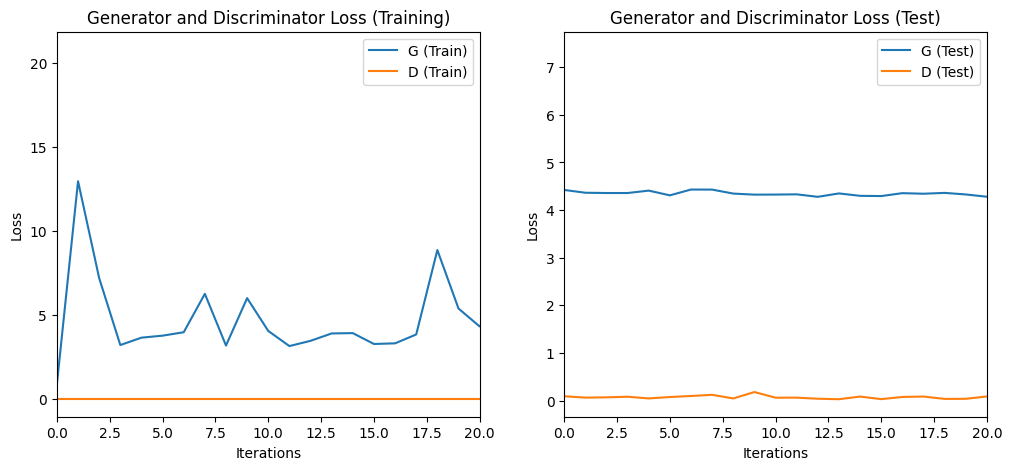

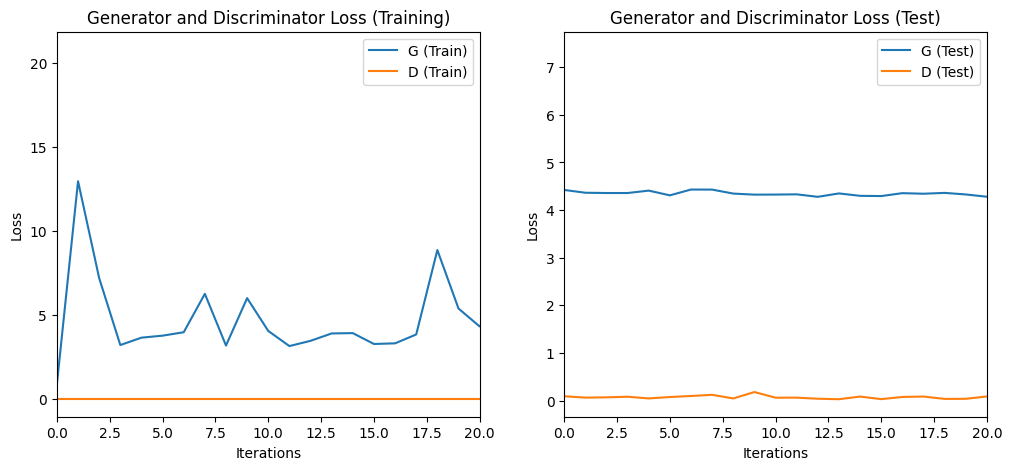

In [26]:
G_losses_train_2, D_losses_train_2, G_losses_test_2, D_losses_test_2 = train_loop(
    train_dataloader, 
    test_dataloader,
    discriminator_2,
    generator_2,
    criterion,
    shedul_step=10,
    num_epochs=3
)

### Variant 3

In [27]:
z_dim = 100  # размерность входного шума
img_channels = 3  # количество каналов изображения (для RGB)
features_d = 128  # определяет сложность модели дискриминатора
features_g = 128  # количество фичей, которое будет использовать генератор

# Оптимизаторы
lr = 0.0002
beta1 = 0.5

In [28]:
generator_3 = Generator_2().to(device)
optimizerG = optim.Adam(generator_3.parameters(), lr=lr, betas=(beta1, 0.999))

In [29]:
discriminator_3 = Discriminator(img_channels, features_d).to(device)
optimizerD = optim.Adam(discriminator_3.parameters(), lr=lr, betas=(beta1, 0.999))

In [30]:
# Функция потерь
criterion = nn.BCELoss()

5065it [16:05,  5.25it/s]



TRAIN epoch_0
G_loss:6.6195
D_loss:0.46803



100%|██████████| 1267/1267 [01:23<00:00, 15.25it/s]


TEST epoch_0
G_loss:2.8768
D_loss:0.16282




5065it [16:05,  5.25it/s]



TRAIN epoch_1
G_loss:7.1703
D_loss:0.25081



100%|██████████| 1267/1267 [01:22<00:00, 15.27it/s]


TEST epoch_1
G_loss:3.2475
D_loss:0.12215




5065it [16:05,  5.25it/s]



TRAIN epoch_2
G_loss:7.9938
D_loss:0.19149



100%|██████████| 1267/1267 [01:22<00:00, 15.29it/s]



TEST epoch_2
G_loss:3.6267
D_loss:0.11231



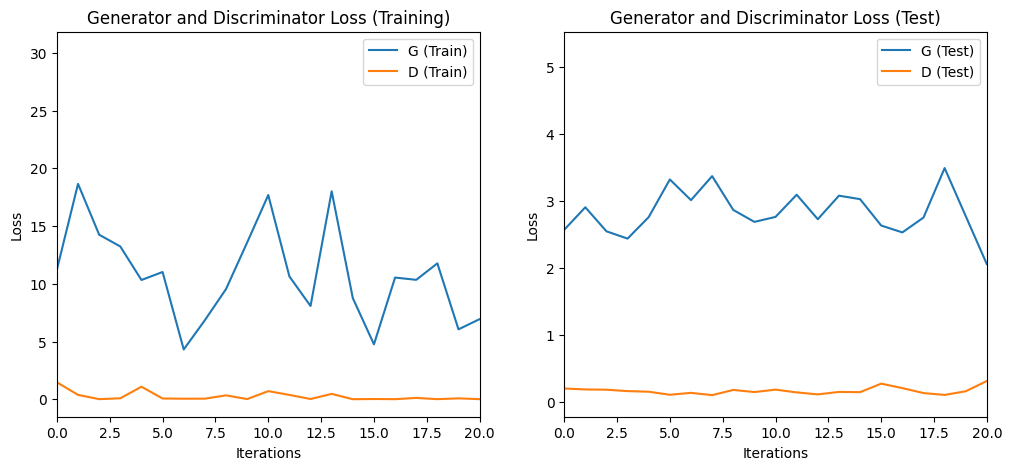

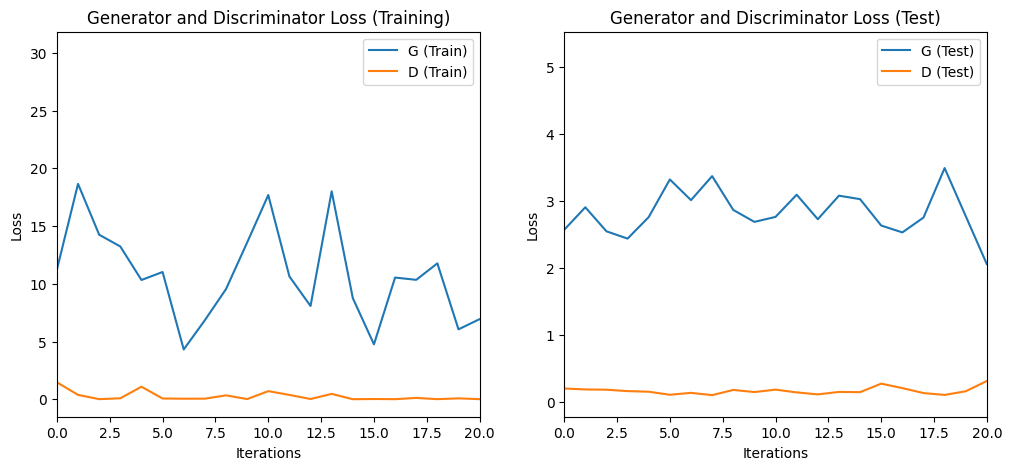

In [31]:
G_losses_train_3, D_losses_train_3, G_losses_test_3, D_losses_test_3 = train_loop(
    train_dataloader, 
    test_dataloader,
    discriminator_3,
    generator_3,
    criterion,
    shedul_step=1,
    num_epochs=3
)

### Variant 4

In [32]:
z_dim = 100  # размерность входного шума
img_channels = 3  # количество каналов изображения (для RGB)
features_d = 128  # определяет сложность модели дискриминатора
features_g = 128  # количество фичей, которое будет использовать генератор

# Оптимизаторы
lr = 0.0002
beta1 = 0.5

In [33]:
generator_4 = Generator_2().to(device)
optimizerG = optim.Adam(generator_4.parameters(), lr=lr, betas=(beta1, 0.999))

In [34]:
discriminator_4 = Discriminator(img_channels, features_d).to(device)
optimizerD = optim.Adam(discriminator_4.parameters(), lr=lr, betas=(beta1, 0.999))

In [35]:
# Функция потерь
criterion = nn.BCELoss()

5065it [10:02,  8.40it/s]



TRAIN epoch_0
G_loss:1.8894
D_loss:0.44942



100%|██████████| 1267/1267 [01:23<00:00, 15.21it/s]


TEST epoch_0
G_loss:0.77746
D_loss:1.1383




5065it [10:02,  8.40it/s]



TRAIN epoch_1
G_loss:1.5887
D_loss:0.42091



100%|██████████| 1267/1267 [01:23<00:00, 15.20it/s]


TEST epoch_1
G_loss:1.1748
D_loss:0.97366




5065it [10:02,  8.40it/s]



TRAIN epoch_2
G_loss:2.6192
D_loss:0.32472



100%|██████████| 1267/1267 [01:23<00:00, 15.16it/s]



TEST epoch_2
G_loss:1.3616
D_loss:0.47532



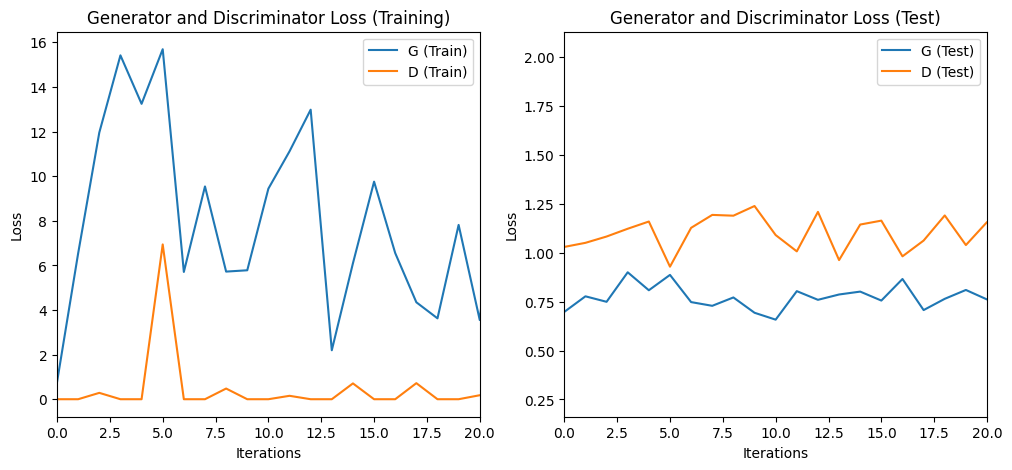

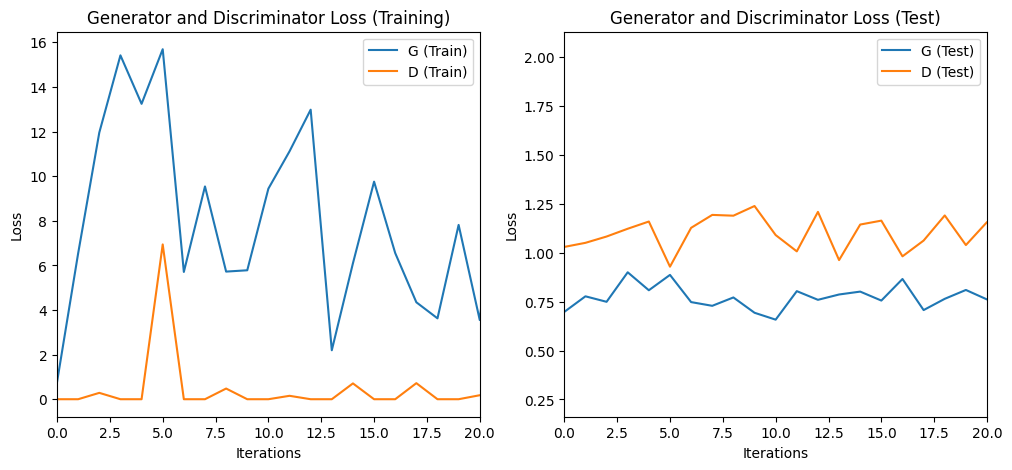

In [36]:
G_losses_train_4, D_losses_train_4, G_losses_test_4, D_losses_test_4 = train_loop(
    train_dataloader, 
    test_dataloader,
    discriminator_4,
    generator_4,
    criterion,
    shedul_step=3,
    num_epochs=3
)

# Примеры работы

In [37]:
def show_and_save_tensor_images(tensor):
    # Проверяем, что тензор 4-мерный [b, c, h, w]
    if tensor.dim() != 4:
        raise ValueError("Тензор должен быть 4-мерным [b, c, h, w]")

    # Переставляем оси тензора для корректного отображения (b, c, h, w) -> (b, h, w, c)
    tensor = tensor.permute(0, 2, 3, 1)

    # Преобразуем тензор в numpy массив
    images = tensor.cpu().detach().numpy()

    for i, image in enumerate(images):
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        plt.show()

        # Сохраняем изображение
        pil_img = Image.fromarray((image * 255).astype('uint8'))
        pil_img.save(f"image_{i+1}.png")

In [38]:
def get_imgs(generator):
    generator = generator.eval()
    noise_1 = torch.randn(1, 100).to(device)
    noise_2 = torch.randn(1, 100).to(device)
    fake_1 = generator(noise_1)
    fake_2 = generator(noise_2)
    generator = generator.train()

    show_and_save_tensor_images(fake_1)
    show_and_save_tensor_images(fake_2)

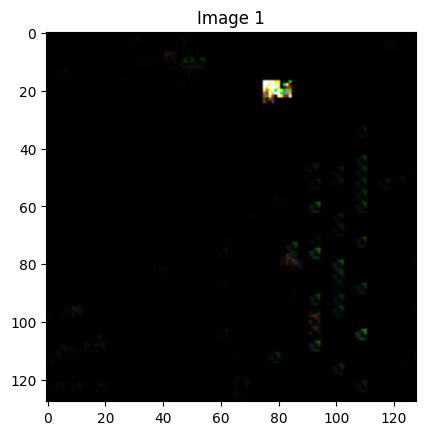

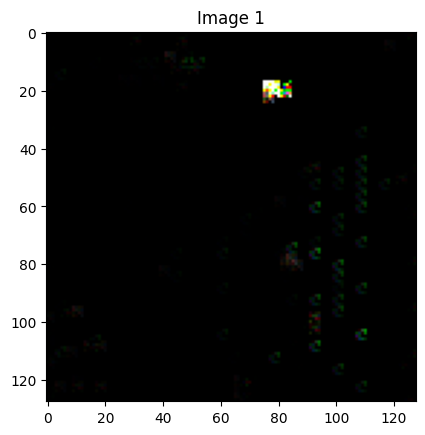

In [39]:
get_imgs(generator_1)

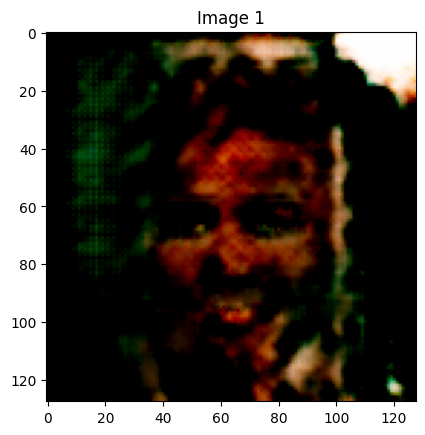

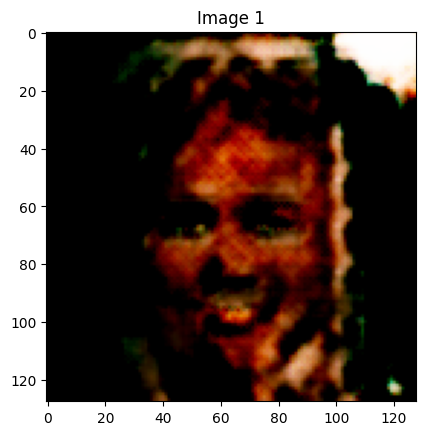

In [40]:
get_imgs(generator_2)

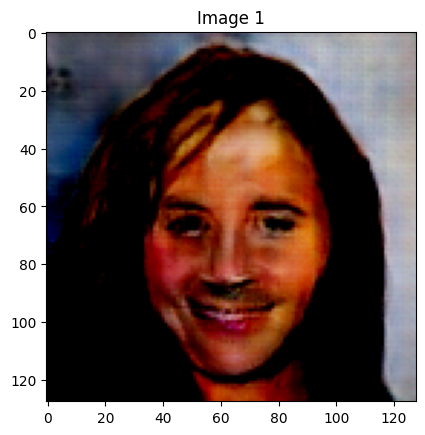

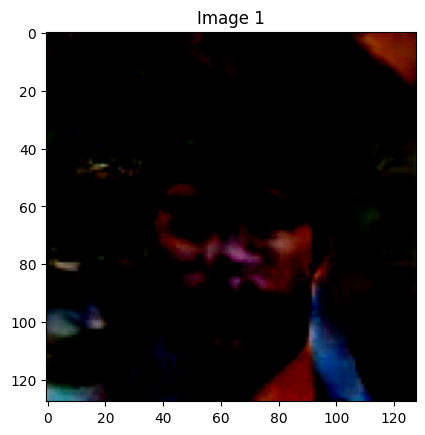

In [41]:
get_imgs(generator_3)

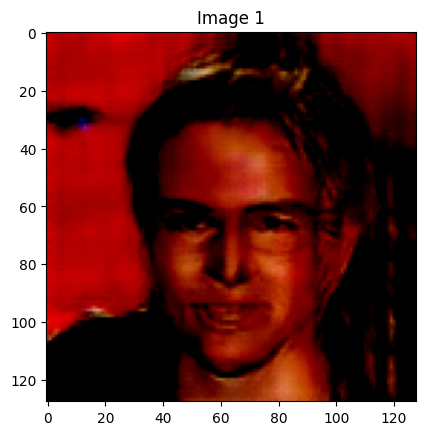

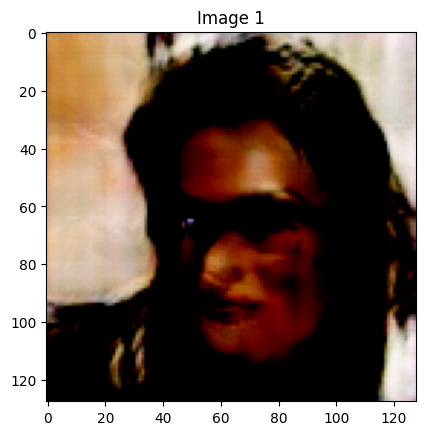

In [43]:
get_imgs(generator_4)